# $J$-factors Maps

Making bidimensional $J$-factors maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp

In [2]:
from dm.profiles import MassProfileNFW, MassProfileEinasto, MassProfileIsothermal, MassProfileBurkert, MassProfileMoore

In [3]:
plt.style.use('astroph')

#### Grid generator

In [4]:
def generate_grid(b, l):
    B, L = np.meshgrid(b, l)
    thetas = np.arccos(np.cos(B)*np.cos(L))
    return thetas

#### Plot profiles 

In [5]:
def profile_plot(j_factors, b, l, cmap=plt.cm.plasma, **kwargs):
    b_min, b_max = b.min(), b.max()
    l_min, l_max = l.min(), l.max()
    n_b = b.size
    n_l = l.size
    delta_b = (b_max-b_min)/n_b
    delta_l = (l_max-l_min)/n_l
    fig, ax = plt.subplots()
    ax.imshow(j_factors, extent=[b_min, b_max+delta_b, l_min, l_max+delta_l], cmap=cmap, **kwargs)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$b$ ($\degree$)')
    ax.set_ylabel(r'$\ell$ ($\degree$)')
    for x in b:
        ax.axvline(x, color='gray', lw=0.3, alpha=0.6)
    for y in l:
        ax.axhline(y, color='gray', lw=0.3, alpha=0.6)
    

## Profiles

In [6]:
nfw = MassProfileNFW()
einasto = MassProfileEinasto()
isothermal = MassProfileIsothermal()
burkert = MassProfileBurkert()
moore = MassProfileMoore()

## Regions

### ```GC 0.1°```

| Latitude ($b$) or aperture ($\theta$) | Longitude |
|:----: |:---:|
| $\theta < 0.1°$| - |


In [7]:
n1 = 60

In [8]:
b_min1, b_max1, l_min1, l_max1 = -0.1, 0.1, -0.1, 0.1

In [9]:
b1 = np.linspace(b_min1, b_max1, n1)
l1 = np.linspace(l_min1, l_max1, n1)

In [10]:
theta1 = generate_grid(b1, l1)*np.pi/180.0

In [11]:
nfw_map1 = nfw.j_factor_map(theta1, epsrel=1e-3)

In [12]:
einasto_map1 = einasto.j_factor_map(theta1, epsrel=1e-3) 

In [13]:
isothermal_map1 = isothermal.j_factor_map(theta1, epsrel=1e-3)

In [14]:
burkert_map1 = burkert.j_factor_map(theta1, epsrel=1e-3)

In [15]:
moore_map1 = moore.j_factor_map(theta1, epsrel=1e-3)

#### Maps

* NFW

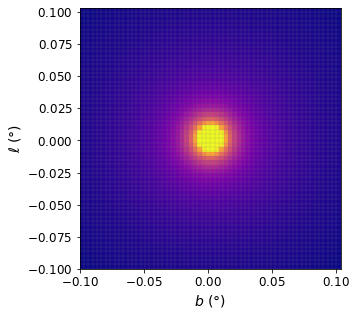

In [16]:
profile_plot(nfw_map1, b1, l1, cmap=plt.cm.plasma, vmax=nfw_map1.max()/4)

* Einasto

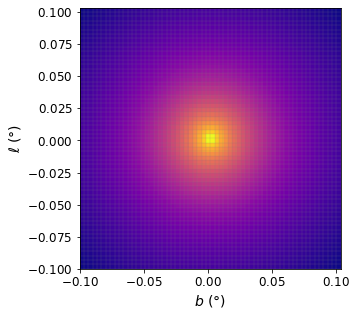

In [17]:
profile_plot(einasto_map1, b1, l1, cmap=plt.cm.plasma)

* Isothermal

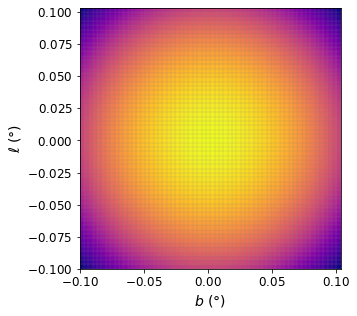

In [18]:
profile_plot(isothermal_map1, b1, l1, cmap=plt.cm.plasma)

* Burkert 

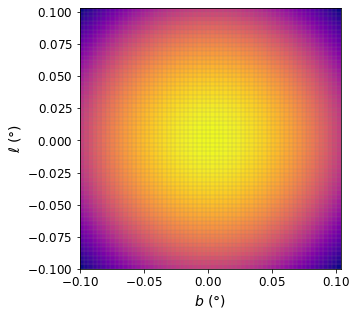

In [19]:
profile_plot(burkert_map1, b1, l1, cmap=plt.cm.plasma)

* Moore

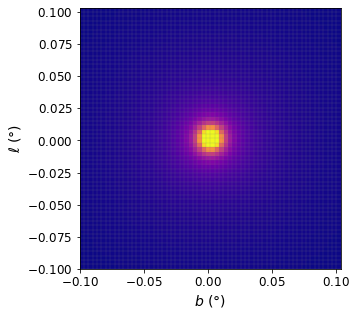

In [20]:
profile_plot(moore_map1, b1, l1, cmap=plt.cm.plasma, vmax=moore_map1.max()/4)

### ```GC 0.14°```

| Latitude ($b$) or aperture ($\theta$) | Longitude |
|:----: |:---:|
| $\theta < 0.14°$| - |


In [21]:
n2 = 50

In [22]:
b_min2, b_max2, l_min2, l_max2 = -0.14, 0.14, -0.14, 0.14

In [23]:
b2 = np.linspace(b_min2, b_max2, n2)
l2 = np.linspace(l_min2, l_max2, n2)

In [24]:
theta2 = generate_grid(b2, l2)*np.pi/180.0

In [25]:
nfw_map2 = nfw.j_factor_map(theta2, epsrel=1e-3)

In [26]:
einasto_map2 = einasto.j_factor_map(theta2, epsrel=1e-3) 

In [27]:
isothermal_map2 = isothermal.j_factor_map(theta2, epsrel=1e-3)

In [28]:
burkert_map2 = burkert.j_factor_map(theta2, epsrel=1e-3)

In [29]:
moore_map2 = moore.j_factor_map(theta2, epsrel=1e-3)

#### Maps

* NFW

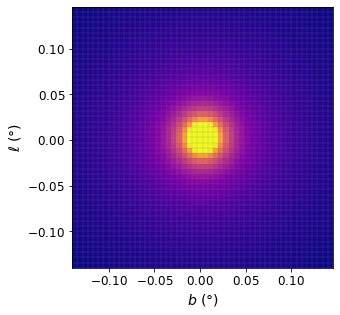

In [30]:
profile_plot(nfw_map2, b2, l2, cmap=plt.cm.plasma, vmax=nfw_map2.max()/4)
ax = plt.gca()
plt.show()

* Einasto

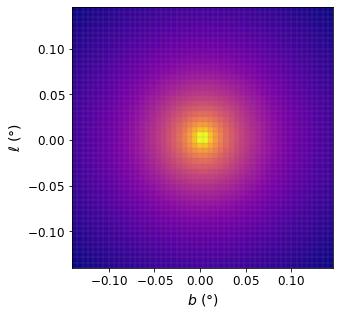

In [31]:
profile_plot(einasto_map2, b2, l2, cmap=plt.cm.plasma)

* Isothermal

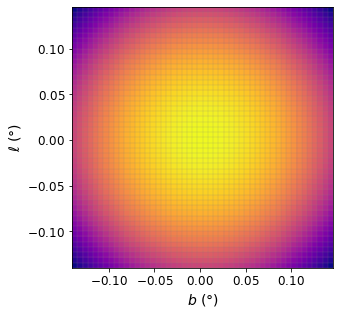

In [32]:
profile_plot(isothermal_map2, b2, l2, cmap=plt.cm.plasma)

* Burkert 

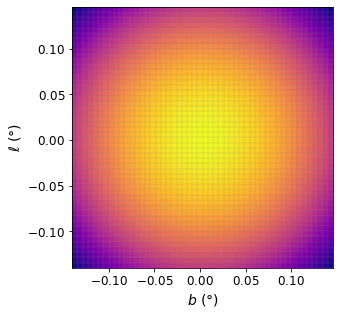

In [33]:
profile_plot(burkert_map2, b2, l2, cmap=plt.cm.plasma)

* Moore

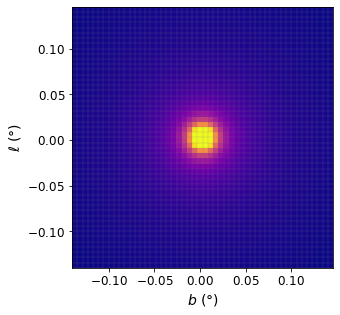

In [34]:
profile_plot(moore_map2, b2, l2, cmap=plt.cm.plasma, vmax=moore_map2.max()/4)

### ```GC 1°```

| Latitude ($b$) or aperture ($\theta$) | Longitude |
|:----: |:---:|
| $\theta < 1°$| - |


In [35]:
n3 = 50

In [36]:
b_min3, b_max3, l_min3, l_max3 = -1.0, 1.0, -1.0, 1.0

In [37]:
b3 = np.linspace(b_min3, b_max3, n3)
l3 = np.linspace(l_min3, l_max3, n3)

In [38]:
theta3 = generate_grid(b3, l3)*np.pi/180.0

In [39]:
nfw_map3 = nfw.j_factor_map(theta3, epsrel=1e-3)

In [40]:
einasto_map3 = einasto.j_factor_map(theta3, epsrel=1e-3) 

In [41]:
isothermal_map3 = isothermal.j_factor_map(theta3, epsrel=1e-3)

In [42]:
burkert_map3 = burkert.j_factor_map(theta3, epsrel=1e-3)

In [43]:
moore_map3 = moore.j_factor_map(theta3, epsrel=1e-3)

#### Maps

* NFW

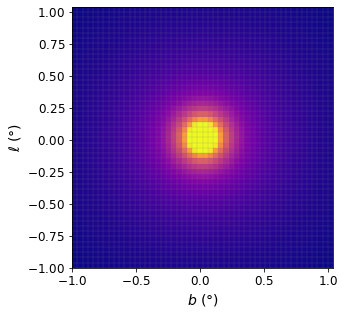

In [44]:
profile_plot(nfw_map3, b3, l3, cmap=plt.cm.plasma, vmax=nfw_map3.max()/4)
ax = plt.gca()
plt.show()

* Einasto

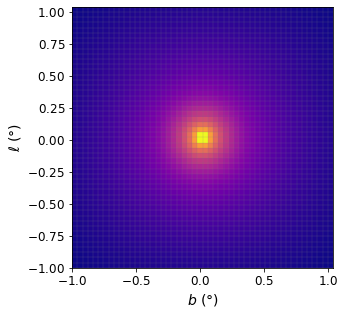

In [45]:
profile_plot(einasto_map3, b3, l3, cmap=plt.cm.plasma)

* Isothermal

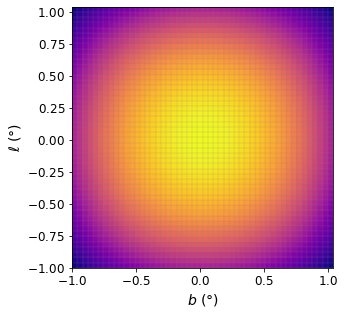

In [46]:
profile_plot(isothermal_map3, b3, l3, cmap=plt.cm.plasma)

* Burkert 

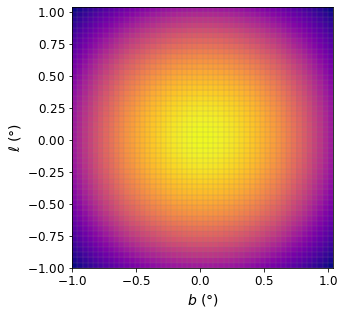

In [47]:
profile_plot(burkert_map3, b3, l3, cmap=plt.cm.plasma)

* Moore

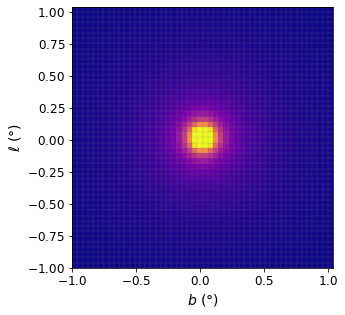

In [48]:
profile_plot(moore_map3, b3, l3, cmap=plt.cm.plasma, vmax=moore_map3.max()/4)